# Baseline model

source code: special seminar (NeuralRecSys_extra)

data: movielens100k

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn

from polara import get_movielens_data
from polara.preprocessing.dataframes import reindex, leave_one_out


from dataprep import transform_indices, generate_interactions_matrix
from evaluation import topn_recommendations, model_evaluate, downvote_seen_items

In [2]:
def fix_torch_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Preparing data

In [3]:
# Read movie data
movielens100k = pd.read_csv("u.data",sep='\t', header = None, names=["userid" , "movieid" , "rating" , "timestamp"])
print(movielens100k.shape)
movielens100k.head(3)

(100000, 4)


,userid,movieid,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116


In [4]:
# set timesplit at 80%

test_timepoint = movielens100k['timestamp'].quantile(
    q=0.80, interpolation='nearest'
)

In [5]:
test_data_ = movielens100k.query('timestamp >= @test_timepoint')

In [6]:
test_data_.nunique()

userid        301
movieid      1448
rating          5
timestamp    9742
dtype: int64

In [7]:
test_data_.shape

(20001, 4)

In [8]:
train_data_ = movielens100k.query(
    'userid not in @test_data_.userid.unique() and timestamp < @test_timepoint'
)

In [9]:
training, data_index = transform_indices(train_data_.copy(), 'userid', 'movieid')

In [10]:
test_data = reindex(test_data_, data_index['items'])

Filtered 231 invalid observations.


In [11]:
test_data.nunique()

userid        299
movieid      1364
rating          5
timestamp    9644
dtype: int64

In [12]:
test_data.shape

(19770, 4)

We sample the last item for each test user.  
As all these users are excluded from the training, and training is additionally filtered by timestamp,
there will be no "recommendation from future" issue - our model is unaware of future correlations.


In [13]:
testset_, holdout_ = leave_one_out(
    test_data, target='timestamp', sample_top=True, random_state=0
)
testset_valid_, holdout_valid_ = leave_one_out(
    testset_, target='timestamp', sample_top=True, random_state=0
)

Let's focus on validation part.

In [14]:
userid = data_index['users'].name
test_users = pd.Index(
    # ensure test users are the same across testing data
    np.intersect1d(
        testset_valid_[userid].unique(),
        holdout_valid_[userid].unique()
    )
)
testset_valid = (
    testset_valid_
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: test_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)
holdout_valid = (
    holdout_valid_
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: test_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)

In [15]:
testset_valid.nunique()

userid        284
movieid      1357
rating          5
timestamp    9289
dtype: int64

In [16]:
holdout_valid.shape

(284, 4)

In [17]:
assert holdout_valid.set_index('userid')['timestamp'].ge(
    testset_valid
    .groupby('userid')
    ['timestamp'].max()
).all()

In [18]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    order = 'timestamp',
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
)
data_description

{'users': 'userid',
 'items': 'movieid',
 'order': 'timestamp',
 'feedback': 'rating',
 'n_users': 642,
 'n_items': 1565}

# Batch Sampler

In [19]:
def sequential_batch_sampler(user_train, usernum, itemnum, batch_size, maxlen, seed, pad_token=None):
    if pad_token is None:
        pad_token = itemnum
    
    def sample(random_state):
        user = random_state.randint(usernum)
        while len(user_train.get(user, [])) <= 1:
            user = random_state.randint(usernum)
        user_items = user_train[user]
        seq = np.full(maxlen, pad_token, dtype=np.int32)
        pos = np.full(maxlen, pad_token, dtype=np.int32)
        neg = np.full(maxlen, pad_token, dtype=np.int32)
        nxt = user_items[-1]
        idx = maxlen - 1
        ts = set(user_items)
        for i in reversed(user_items[:-1]):
            seq[idx] = i
            pos[idx] = nxt
            neg[idx] = random_neq(0, itemnum, ts, random_state)
            nxt = i
            idx -= 1
            if idx == -1:
                break
        return (user, seq, pos, neg)
    
    random_state = np.random.RandomState(seed)
    while True:
        yield zip(*(sample(random_state) for _ in range(batch_size)))


def random_neq(l, r, s, random_state):
    t = random_state.randint(l, r)
    while t in s:
        t = random_state.randint(l, r)
    return t

# SASRec model

The code is adapted from https://github.com/pmixer/SASRec.pytorch

In [20]:
class PointWiseFeedForward(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(PointWiseFeedForward, self).__init__()
        self.conv1 = nn.Conv1d(hidden_units, hidden_units, kernel_size=1)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(hidden_units, hidden_units, kernel_size=1)
        self.dropout2 = nn.Dropout(p=dropout_rate)

    def forward(self, inputs):
        outputs = self.dropout2(self.conv2(self.relu(self.dropout1(self.conv1(inputs.transpose(-1, -2))))))
        outputs = outputs.transpose(-1, -2) # as Conv1D requires (N, C, Length)
        outputs += inputs
        return outputs


class SASRec(nn.Module):
    def __init__(self, item_num, config):
        super(SASRec, self).__init__()
        self.item_num = item_num
        self.pad_token = item_num

        self.item_emb = nn.Embedding(self.item_num+1, config['hidden_units'], padding_idx=self.pad_token)
        self.pos_emb = nn.Embedding(config['maxlen'], config['hidden_units'])
        self.emb_dropout = nn.Dropout(p=config['dropout_rate'])

        self.attention_layernorms = nn.ModuleList() # to be Q for self-attention
        self.attention_layers = nn.ModuleList()
        self.forward_layernorms = nn.ModuleList()
        self.forward_layers = nn.ModuleList()
        self.last_layernorm = nn.LayerNorm(config['hidden_units'], eps=1e-8)

        for _ in range(config['num_blocks']):
            new_attn_layernorm = nn.LayerNorm(config['hidden_units'], eps=1e-8)
            self.attention_layernorms.append(new_attn_layernorm)
            new_attn_layer =  nn.MultiheadAttention(
                config['hidden_units'],config['num_heads'],config['dropout_rate']
            )
            self.attention_layers.append(new_attn_layer)

            new_fwd_layernorm = nn.LayerNorm(config['hidden_units'], eps=1e-8)
            self.forward_layernorms.append(new_fwd_layernorm)

            new_fwd_layer = PointWiseFeedForward(config['hidden_units'], config['dropout_rate'])
            self.forward_layers.append(new_fwd_layer)
        
        fix_torch_seed(config['manual_seed'])
        self.initialize()


    def initialize(self):
        for name, param in self.named_parameters():
            try:
                torch.nn.init.xavier_uniform_(param.data)
            except:
                pass # just ignore those failed init layers


    def log2feats(self, log_seqs):
        device = log_seqs.device
        seqs = self.item_emb(log_seqs)
        seqs *= self.item_emb.embedding_dim ** 0.5
        positions = np.tile(np.arange(log_seqs.shape[1]), [log_seqs.shape[0], 1])
        seqs += self.pos_emb(torch.LongTensor(positions).to(device))
        seqs = self.emb_dropout(seqs)

        timeline_mask = log_seqs == self.pad_token
        seqs *= ~timeline_mask.unsqueeze(-1) # broadcast in last dim

        tl = seqs.shape[1] # time dim len for enforce causality
        attention_mask = ~torch.tril(torch.full((tl, tl), True, device=device))

        for i in range(len(self.attention_layers)):
            seqs = torch.transpose(seqs, 0, 1)
            Q = self.attention_layernorms[i](seqs)
            mha_outputs, _ = self.attention_layers[i](
                Q, seqs, seqs, attn_mask=attention_mask
            )
        
            seqs = Q + mha_outputs
            seqs = torch.transpose(seqs, 0, 1)

            seqs = self.forward_layernorms[i](seqs)
            seqs = self.forward_layers[i](seqs)
            seqs *=  ~timeline_mask.unsqueeze(-1)

        log_feats = self.last_layernorm(seqs) # (U, T, C) -> (U, -1, C)

        return log_feats

    def forward(self, log_seqs, pos_seqs, neg_seqs):
        log_feats = self.log2feats(log_seqs)
        pos_embs = self.item_emb(pos_seqs)
        neg_embs = self.item_emb(neg_seqs)

        pos_logits = (log_feats * pos_embs).sum(dim=-1)
        neg_logits = (log_feats * neg_embs).sum(dim=-1)

        return pos_logits, neg_logits


    def score(self, seq):
        '''
        Takes 1d sequence as input and returns prediction scores.
        '''
        maxlen = self.pos_emb.num_embeddings
        log_seqs = torch.full([maxlen], self.pad_token, dtype=torch.int64, device=seq.device)
        log_seqs[-len(seq):] = seq[-maxlen:]
        log_feats = self.log2feats(log_seqs.unsqueeze(0))
        final_feat = log_feats[:, -1, :] # only use last QKV classifier

        item_embs = self.item_emb.weight
        logits = item_embs.matmul(final_feat.unsqueeze(-1)).squeeze(-1)
        return logits

## Training 

In [21]:
def data_to_sequences(data, data_description):
    userid = data_description['users']
    itemid = data_description['items']
    sequences = (
        data.sort_values([userid, data_description['order']])
        .groupby(userid, sort=False)[itemid].apply(list)
    )
    return sequences

In [22]:
def prepare_sasrec_model(config, data, data_description):
    n_users = data_description['n_users']    
    n_items = data_description['n_items']    
    model = SASRec(n_items, config)
    criterion = torch.nn.BCEWithLogitsLoss()
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()

    train_sequences = data_to_sequences(data, data_description)
    sampler = sequential_batch_sampler(
        train_sequences, n_users, n_items,
        batch_size = config['batch_size'],
        maxlen = config['maxlen'],
        seed = config['sampler_seed'],
        pad_token = model.pad_token
    )
    n_batches = len(train_sequences) // config['batch_size']
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr = config['learning_rate'],
        betas = (0.9, 0.98)
    )
    return model, sampler, n_batches, criterion, optimizer

In [23]:
def train_sasrec_epoch(model, num_batch, l2_emb, sampler, optimizer, criterion, device):
    model.train()
    pad_token = model.pad_token
    losses = []
    for _ in range(num_batch):
        _, *seq_data = next(sampler)
        # convert batch data into torch tensors
        seq, pos, neg = (torch.LongTensor(np.array(x)).to(device) for x in seq_data)
        pos_logits, neg_logits = model(seq, pos, neg)
        pos_labels = torch.ones(pos_logits.shape, device=device)
        neg_labels = torch.zeros(neg_logits.shape, device=device)
        optimizer.zero_grad()
        indices = torch.where(pos != pad_token)
        loss = criterion(pos_logits[indices], pos_labels[indices])
        loss += criterion(neg_logits[indices], neg_labels[indices])
        if l2_emb != 0:
            for param in model.item_emb.parameters():
                loss += l2_emb * torch.norm(param)**2
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [24]:
def build_sasrec_model(config, data, data_description):
    '''Simple MF training routine without early stopping'''
    model, sampler, n_batches, criterion, optimizer = prepare_sasrec_model(config, data, data_description)
    device = 'cpu'
    if torch.cuda.is_available():
        device = torch.device(f'cuda:{torch.cuda.current_device()}') 
    losses = {}
    for epoch in tqdm(range(config['num_epochs'])):
        losses[epoch] = train_sasrec_epoch(
            model, n_batches, config['l2_emb'], sampler, optimizer, criterion, device
        )
    return model, losses

In [25]:
config = dict(
    num_epochs = 20,
    maxlen = 200,
    hidden_units = 64,
    dropout_rate = 0.4,
    num_blocks = 1,
    num_heads = 1,
    batch_size = 64,
    sampler_seed = 99,
    manual_seed = 111,
    learning_rate = 1e-3,
    l2_emb = 0,
)

In [26]:
model, losses = build_sasrec_model(config, training, data_description)

  0%|          | 0/20 [00:00<?, ?it/s]

In [27]:
len(losses)

20

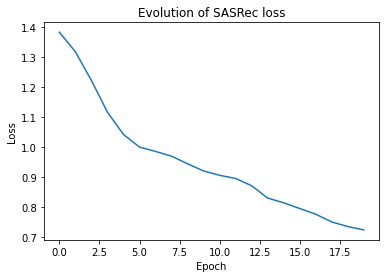

In [28]:
pd.Series(losses).apply(np.mean).plot(title='Evolution of SASRec loss', xlabel='Epoch', ylabel='Loss');

In [29]:
len(losses[0])

10

In [30]:
losses[0]

[1.407297134399414,
 1.40506911277771,
 1.3978288173675537,
 1.3914268016815186,
 1.3848435878753662,
 1.3803174495697021,
 1.3763352632522583,
 1.3612090349197388,
 1.369307279586792,
 1.3611211776733398]

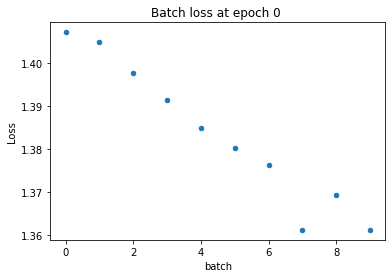

In [31]:
epoch = 0
epoch_loss_series = pd.Series(losses[epoch], name='Loss').rename_axis('batch')
ax = epoch_loss_series.reset_index().plot.scatter(
    x='batch', y='Loss', title=f'Batch loss at epoch {epoch} '
)

In [32]:
epoch_loss_series

batch
0    1.407297
1    1.405069
2    1.397829
3    1.391427
4    1.384844
5    1.380317
6    1.376335
7    1.361209
8    1.369307
9    1.361121
Name: Loss, dtype: float64

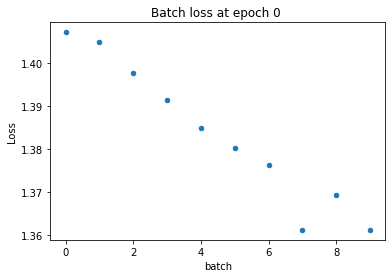

In [33]:
epoch = 0
epoch_loss_series = pd.Series(losses[epoch], name='Loss').rename_axis('batch')
ax = epoch_loss_series.reset_index().plot.scatter(
    x='batch', y='Loss', title=f'Batch loss at epoch {epoch} '
)

# Evaluation

In [34]:
def sasrec_model_scoring(params, data, data_description):
    model = params
    model.eval()
    tensor = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
    test_sequences = data_to_sequences(data, data_description)
    # perform scoring on a user-batch level
    scores = []
    for _, seq in test_sequences.items():
        with torch.no_grad():
            predictions = model.score(tensor(seq))
        scores.append(predictions.detach().cpu().numpy())
    return np.concatenate(scores, axis=0)

In [35]:
sasrec_scores = sasrec_model_scoring(model, testset_valid, data_description)

In [36]:
downvote_seen_items(sasrec_scores, testset_valid, data_description)

In [37]:
sasrec_recs = topn_recommendations(sasrec_scores, topn=5)
model_evaluate(sasrec_recs, holdout_valid, data_description)

(0.09859154929577464, 0.05275821596244131, 0.09456869009584665)